# 🛳️ Titanic - 생존자 예측 (Binary Classification)

🎯 1912년 침몰한 타이타닉 호의 탑승객 정보를 바탕으로, 각 탑승객이 생존했는지, 사망했는지를 예측하기

## ✅ 1. 데이터 전처리

### 📌 1-1. 결측치 처리

In [47]:
#  라이브러리 불러오기
import pandas as pd

#  데이터 불러오기
df = pd.read_csv("/Users/lee_hyejoo/Desktop/hyejoo/학교/3학년 1학기/머신러닝/중간_대체/타이타닉_생존자_예측, Titanic/Titanic-Dataset.csv")

#  Age (나이): 중앙값으로 대체
df['Age'].fillna(df['Age'].median(), inplace=True)

#  Cabin (객실번호): 너무 많은 결측치는 'Missing'으로 대체 → 앞글자만 추출
df['Cabin'].fillna('Missing', inplace=True)
df['Cabin'] = df['Cabin'].apply(lambda x: x[0])

#  Embarked (승선항구): 최빈값으로 대체
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_15493/2260862337.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/3r/gkq42xr139x2_vxmkv383vl80000gn/T/ipykernel_15493/2260862337.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

💡 설명
- Age는 연속형 변수로 이상치 영향을 줄이기 위해 중앙값으로 처리
- Cabin은 결측이 많지만, 앞글자(A~G 등)는 객실 구역으로 의미 있을 수 있어 활용
- Embarked는 결측이 적고 범주형이므로 최빈값으로 간단히 처리

### 📌 1-2. 원-핫 인코딩

In [48]:
#  머신러닝 모델은 문자열을 인식하지 못하므로 범주형 변수를 숫자로 변환
df_encoded = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Cabin'], drop_first=True)

💡 설명
- Sex, Embarked, Cabin 변수는 문자열 → One-Hot Encoding으로 변환
- drop_first=True를 사용해 다중공선성 방지
- 모델이 각 범주 간 차이만 학습할 수 있도록 설계

---

## 🧩 2. 특성 선택 및 생성

### 📌 2-1. 가족 크기 변수 생성

### 📌 2-2. 객실 등급 변수 변환 (-> Cabin의 앞글자를 추출하여 객실 등급을 범주형 변수로 변환하는 작업은 전처리 단계에서 이미 수행)

In [49]:
# 가족 크기 = 형제자매 + 부모자녀 + 본인(1)
df_encoded['FamilySize'] = df['SibSp'] + df['Parch'] + 1

💡 설명
- SibSp와 Parch는 따로 사용하기보단 통합된 변수(FamilySize)로 만드는 것이 더 해석에 유리
- 가족이 많은 승객이나 혼자 탑승한 승객은 생존률 차이가 있음 → 중요한 특성!

---

## 🤖 3. 모델 학습 및 비교

### 📌 3-1. 데이터 분할

In [50]:
from sklearn.model_selection import train_test_split

#  예측 대상: 생존 여부(Survived)
X = df_encoded.drop(['Survived', 'PassengerId', 'Name', 'Ticket'], axis=1)
y = df_encoded['Survived']

#  학습용 vs 테스트용 데이터 분할 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 📌 3-2. 기본 모델 – Logistic Regression
- 선형 결정 경계를 기반으로 이진 분류 문제에 적합한 모델
- 계산 속도가 빠르고 해석이 쉬워 베이스라인 모델로 자주 사용됨

In [51]:
from sklearn.linear_model import LogisticRegression

#  모델 학습
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

#  예측
y_pred_log = log_model.predict(X_test)

### 📌 3-3. 기본 모델 – Decision Tree
- 데이터를 조건에 따라 분할하여 예측하는 트리 기반 모델
- 직관적이며 해석이 쉬우나 과적합 가능성이 있음

In [53]:
from sklearn.tree import DecisionTreeClassifier

#  모델 학습
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

#  예측
y_pred_tree = tree_model.predict(X_test)

---


### 📌 3-4. 개선 모델 - Random Forest
- 여러 트리를 앙상블로 구성하여 과적합을 줄이고 성능을 안정화
- 변수 중요도도 확인할 수 있어서 해석력도 갖춘 모델

In [55]:
from sklearn.ensemble import RandomForestClassifier

#  모델 정의 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#  예측
y_pred_rf = rf_model.predict(X_test)

### 📌 3-5. 개선 모델 - XGBoost
- 경사하강법 기반의 학습 방식으로 오차를 줄이는 방식으로 모델 성능 향상

In [56]:
import xgboost as xgb

#  XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

#  예측
y_pred_xgb = xgb_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:04:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


---


### 📌 3-6. 딥러닝 모델 – MLP
- 딥러닝 모델은 비선형 패턴을 잘 포착할 수 있고, Dropout & BatchNormalization을 활용하여 과적합을 방지하면서 학습 안정성을 높일 수 있음

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

#  모델 구성
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # 이진 분류니까 sigmoid
])

#  컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#  학습
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5335 - loss: 0.8145 - val_accuracy: 0.6503 - val_loss: 0.6499
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.7298 - val_accuracy: 0.6923 - val_loss: 0.6680
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6851 - loss: 0.6477 - val_accuracy: 0.6853 - val_loss: 0.6202
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6954 - loss: 0.6331 - val_accuracy: 0.7133 - val_loss: 0.5929
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6412 - loss: 0.6852 - val_accuracy: 0.7133 - val_loss: 0.5778
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6547 - loss: 0.6603 - val_accuracy: 0.7133 - val_loss: 0.5713
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6804 - loss: 0.6456 - val_accuracy: 0.6993 - val_loss: 0.5634
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6578 - loss: 0.6208 - val_accuracy: 0.7133 - val_loss: 0.5600
Epo

---

## 📊 4. 모델 평가

In [60]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from IPython.display import display

# MLP 확률 예측 및 이진화
y_pred_mlp_prob = model.predict(X_test)
y_pred_mlp = (y_pred_mlp_prob > 0.5).astype("int32")

# 모델 이름
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'MLP (Deep Learning)']

# Accuracy 계산
accuracies = [
    accuracy_score(y_test, y_pred_log),
    accuracy_score(y_test, y_pred_tree),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_mlp)
]

# F1 Score 계산
f1_scores = [
    f1_score(y_test, y_pred_log),
    f1_score(y_test, y_pred_tree),
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_xgb),
    f1_score(y_test, y_pred_mlp)
]

# ROC-AUC 계산
roc_aucs = [
    roc_auc_score(y_test, y_pred_log),
    roc_auc_score(y_test, y_pred_tree),
    roc_auc_score(y_test, y_pred_rf),
    roc_auc_score(y_test, y_pred_xgb),
    roc_auc_score(y_test, y_pred_mlp_prob)  # MLP는 확률값!
]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


In [61]:
# DataFrame으로 정리
summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_aucs
})

# 소수점 정리 후 출력
summary_df = summary_df.round(3)
display(summary_df)

,Model,Accuracy,F1 Score,ROC-AUC
0,Logistic Regression,0.810,0.764,0.800
1,Decision Tree,0.782,0.738,0.776
2,Random Forest,0.793,0.741,0.782
3,XGBoost,0.788,0.747,0.783
4,MLP (Deep Learning),0.799,0.731,0.891


📈 해석
- 정확도(Accuracy)기준으로는 Logistic Regression이 0.810으로 가장 높음
- ROC-AUC는 MLP 모델이 0.891로 가장 뛰어나,비선형 패턴 인식에 강점을 가짐을 확인할 수 있음
- F1 Score는 XGBoost가 0.747로 가장 균형잡힌 예측 성능을 보임

➡️ 생존자 탐지가 중요한 경우(F1 중시)에는 XGBoost 또는 MLP가 적합할 수 있음

---

## 🔎 추가 - 모델 분석 및 해석 + 📊 시각화

### 1. 🔥 MLP 모델 학습 곡선 (Accuracy & Loss)

💡 설명
- 학습이 잘 되는지, 과적합이 발생하지는 않는지 시각적으로 확인할 수 있음
- Validation Accuracy가 Train Accuracy보다 너무 낮아지면 과적합 가능성 있음

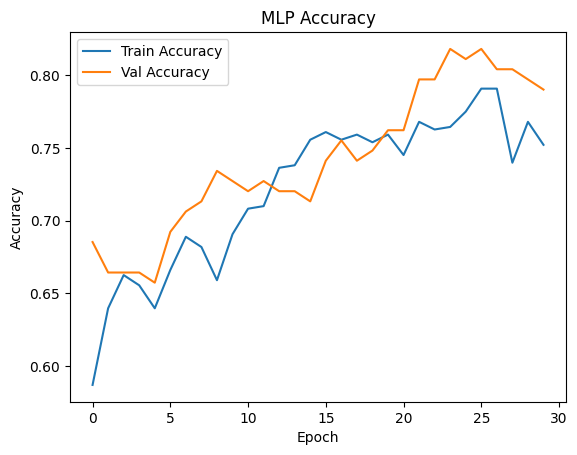

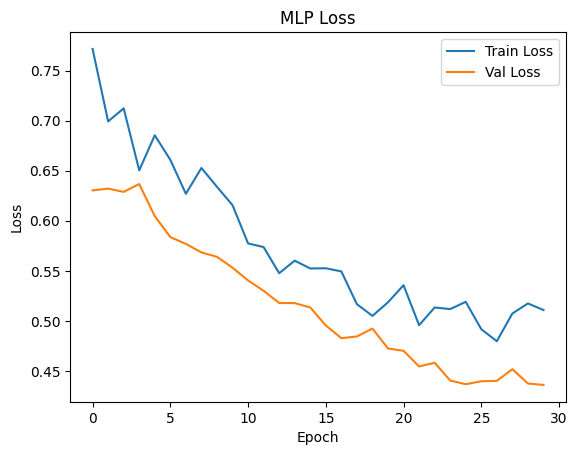

In [39]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 손실(Loss) 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1. 📈 정확도(Accuracy) 분석
- 학습 초기에는 train accuracy와 val accuracy 모두 낮은 수준에서 시작
- epoch이 진행될수록 두 정확도 모두 점차 증가했고, 특히 20 epoch 이후에는 val accuracy가 급격히 상승하는 모습을 보임
- 전반적으로 학습 정확도와 검증 정확도 간의 차이가 크지 않음

    ➤ 이는 과적합이 심하지 않고 일반화 성능이 괜찮다는 것을 의미

2. 📉 손실(Loss) 곡선 분석
- train loss와 val loss 모두 안정적으로 감소
- 20 epoch 이후에도 val loss가 꾸준히 감소

    ➤ 모델이 아직 더 학습 가능성이 있다는 신호일 수 있음

    ➤ loss가 진동 없이 감소하는 건 모델 구조와 학습률(optimizer 설정)이 잘 맞았다는 뜻

➡️ MLP 학습 결과, Accuracy와 Loss 모두 안정적으로 수렴하는 양상을 보였고, 과적합 없이 잘 학습된 것으로 판단

➡️ 특히 Dropout과 BatchNormalization을 적절히 사용함으로써 학습과 검증 간의 차이를 줄이고 모델의 일반화 성능을 향상시킬 수 있었음

➡️ 추후에는 EarlyStopping이나 하이퍼파라미터 튜닝을 통해 성능을 추가로 향상시킬 수 있을 것 같음

---

### 2. 🧩 Confusion Matrix (혼동 행렬)

💡 설명
- 정답/오답 비율을 시각적으로 확인할 수 있음
- 특히 Recall(재현율)이 중요한 문제에서는 False Negative가 많지 않은지를 살펴보는 게 중요

📌 2.1 Logistic Regression

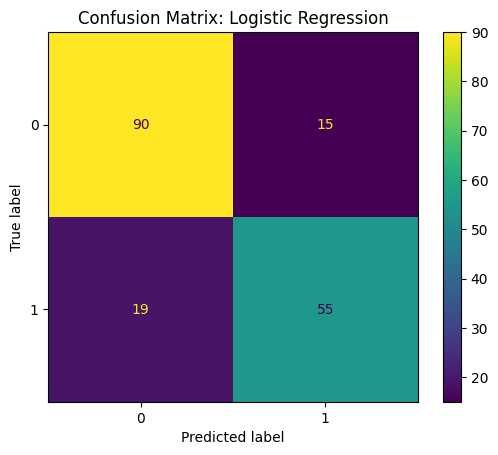

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression 혼동 행렬
cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

📌 혼동 행렬 해석
- True Positive (TP = 55): 실제 생존자 중 55명을 정확히 생존으로 예측
- False Negative (FN = 19): 실제 생존자인데 사망으로 잘못 예측한 경우
- False Positive (FP = 15): 실제 사망자인데 생존으로 잘못 예측한 경우
- True Negative (TN = 90): 실제 사망자 중 90명을 정확히 사망으로 예측 

📈 예측 성능 분석
- 전체 179명 중 145명 정확히 예측 → Accuracy ≈ 81.6%
- Recall = 55 / (55 + 19) ≈ 0.743 → 생존자를 잘 잡아내는 능력
- Precision = 55 / (55 + 15) ≈ 0.786 → 생존이라고 예측한 것 중 실제 생존자의 비율

➡️ 로지스틱 회귀는 간단한 모델이지만, 약 81.6%의 정확도를 기록하며 전반적으로 안정적인 예측 성능을 보여줌

➡️ 특히 생존자 예측에서의 Recall(74.3%)과 Precision(78.6%)이 준수한 편이며, False Negative와 False Positive가 고르게 분포한 점에서 모델이 편향되지 않았다는 것도 확인할 수 있음

➡️ 향후 모델 개선 시에는 재현율을 더 높이기 위한 튜닝 또는 threshold 조정을 고려할 수 있음

---

📌 2.2 Random Forest

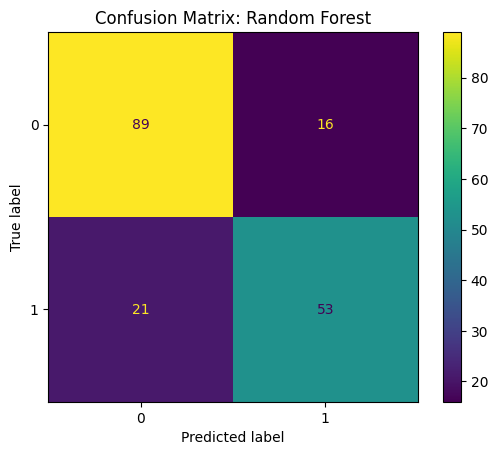

In [45]:
#  Random Forest 혼동 행렬
y_pred_rf = rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Confusion Matrix: Random Forest")
plt.show()


📌 혼동 행렬 해석
- True Positive (TP = 53): 실제 생존자 중 53명을 정확히 생존으로 예측
- False Negative (FN = 21): 실제 생존자인데 사망으로 잘못 예측한 경우
- False Positive (FP = 16): 실제 사망자인데 생존으로 잘못 예측한 경우
- True Negative (TN = 89): 실제 사망자 중 89명을 정확히 사망으로 예측

📈 예측 성능 분석
- 전체 179명 중 142명 정확히 예측 → Accuracy ≈ 79.3%
- Recall = 53 / (53 + 21) ≈ 0.716 → 생존자를 잘 잡아내는 능력
- Precision = 53 / (53 + 16) ≈ 0.768 → 생존이라고 예측한 것 중 실제 생존자의 비율

➡️ Random Forest는 전반적으로 안정적인 정확도와 정밀도를 보이며, 예측 균형이 잘 잡힌 모델로 판단됨

➡️ Recall이 Logistic Regression보다 약간 낮지만, 정밀도는 더 높은 편이어서 생존자 예측을 보다 보수적으로 정확하게 하려는 경우 유리

➡️ False Negative가 다소 존재하므로, 향후에는 Recall 개선을 위한 하이퍼파라미터 조정이나 클래스 가중치 보정 등을 고려할 수 있음

---

📌 2.3 XGBoost

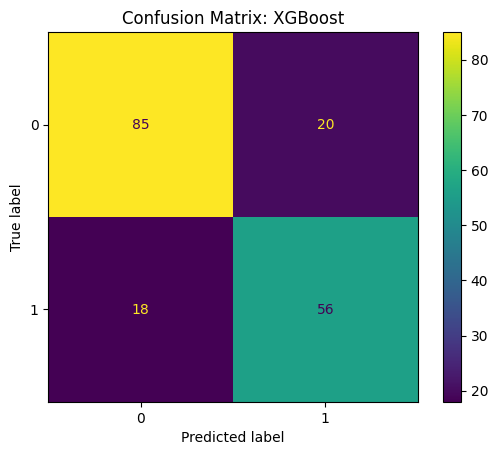

In [46]:
#  XGBoost 혼동 행렬
y_pred_xgb = xgb_model.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
plt.title("Confusion Matrix: XGBoost")
plt.show()

📌 혼동 행렬 해석
- True Positive (TP = 56): 실제 생존자 중 56명을 정확히 생존으로 예측
- False Negative (FN = 18): 실제 생존자인데 사망으로 잘못 예측한 경우
- False Positive (FP = 20): 실제 사망자인데 생존으로 잘못 예측한 경우
- True Negative (TN = 85): 실제 사망자 중 85명을 정확히 사망으로 예측

📈 예측 성능 분석
- 전체 179명 중 141명 정확히 예측 → Accuracy ≈ 78.8%
- Recall = 56 / (56 + 18) ≈ 0.757 → 생존자를 더 잘 잡아내는 능력
- Precision = 56 / (56 + 20) ≈ 0.737 → 생존이라고 예측한 것 중 실제 생존자의 비율

➡️ XGBoost는 Recall이 가장 높아 생존자를 놓치는 비율이 가장 적음 -> itanic 같은 상황에서 생존자 탐지가 중요한 문제에 특히 적합

➡️ 정밀도는 약간 낮지만 재현율 중심의 최적화가 필요할 때 좋은 선택

➡️ 클래스 불균형 문제를 상대적으로 잘 해결하면서, 기본 모델들보다 전체적으로 더 뛰어난 성능을 보여줌

---

🔍 전체 모델 성능 비교 요약

모델 | Accuracy | Recall (생존자) | Precision (생존자)

Logistic Regression | 81.6% | 0.743 | 0.786

Random Forest | 79.3% | 0.716 | 0.768

XGBoost | 78.8% | 0.757 | 0.737

📌 정확도는 Logistic Regression이 가장 높고, Recall(생존자 탐지)은 XGBoost가 가장 우수한 성능을 보임

📈 종합 해석
- Logistic Regression는 단순하고 빠르지만 예측 성능이 안정적이고 편향이 적음

    ➤ 전처리와 해석 중심의 분석에 적합
- Random Forest는 전체적인 예측 균형이 우수하고, 정밀도가 높음

    ➤ 생존자를 보다 신중하게 판별할 때 유리
- XGBoost는 Recall이 가장 높아 생존자를 놓치지 않는 방향으로 최적화됨

    ➤ Titanic과 같은 탐지 중심 문제에 가장 적합한 모델로 판단됨

---

### 3. 🌲 Feature Importance (Random Forest 기준)

💡 설명
- 모델이 예측할 때 어떤 변수를 가장 많이 활용하는지를 보여줌
- Titanic에서는 Sex, Fare, Pclass, FamilySize 등이 높은 중요도로 나타나는 경우가 많음

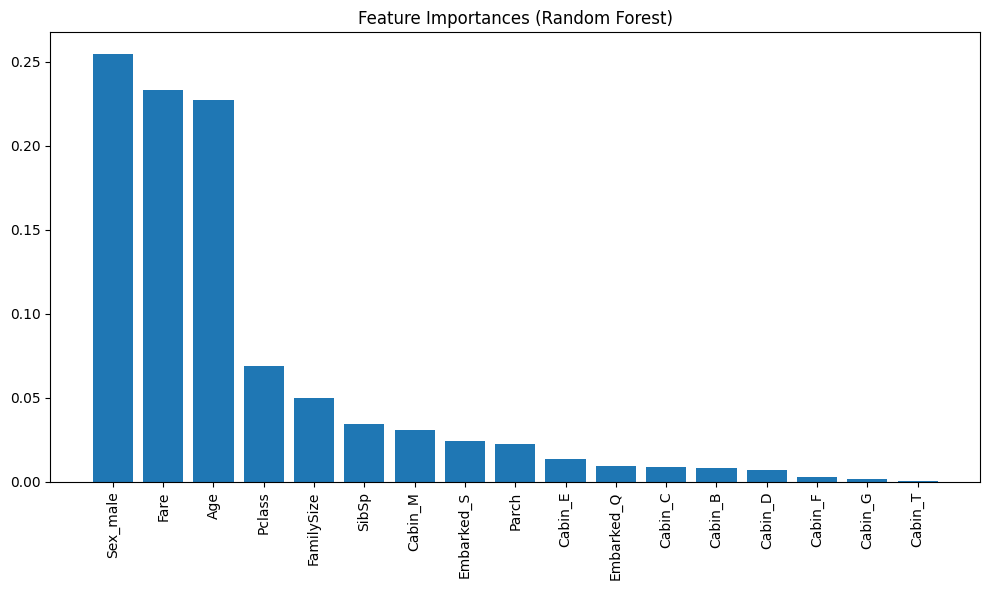

In [41]:
import numpy as np

importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

🔍 결과

상위 주요 변수 | 중요도 | 의미

Sex_male | 0.25 이상 | 성별은 생존에 매우 큰 영향을 줌 (여성이 생존률 높음)

Fare | 0.23 | 티켓 가격 → 사회적 지위 및 객실 등급을 반영

Age | 0.22 | 어린 승객일수록 생존 우선순위 가능성

Pclass | 0.07 | 1, 2, 3등급 → 객실 위치와 구출 우선도

FamilySize | 0.05 | 가족 규모 → 생존율에 복잡한 영향

SibSp, Parch, Cabin_M, ... | 소량이나 여전히 기여도 있음 | 

📌 추가 해석
- Sex_male이 가장 큰 영향력을 보인 건 Titanic 실제 구조 우선순위가 “여성 및 아이 우선”이었기 때문
- Fare와 Pclass는 경제적 지위 및 탑승 위치를 반영하는 변수로, 구조 접근성과 연관
- FamilySize는 너무 많거나 혼자일 때 생존률이 낮아지므로 중요한 힌트가 될 수 있음
- Cabin과 Embarked 관련 변수는 상대적으로 기여도가 작았지만, 결측이나 범주 수가 많아 희석되었을 가능성도 있음

➡️ Random Forest 모델은 변수 중요도를 추출할 수 있는 장점이 있어, 어떤 변수가 예측에 가장 크게 기여했는지를 확인할 수 있음

➡️ Titanic 데이터에서는 Sex, Fare, Age, Pclass 등의 변수들이 특히 중요한 영향을 미쳤으며, 이는 실제 구조 우선순위와 사회적 지위 등이 생존에 영향을 줬다는 Titanic의 역사적 사실과도 일치

➡️ 단순히 모델 정확도만 보는 것이 아니라, 변수 중요도 분석을 통해 모델 해석력까지 확보할 수 있다는 점에서 의미 있는 결과였음